In [ ]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns
sns.set_context('paper',font_scale=3.3)
sns.set_style('ticks')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EBSCO/household_power_consumption.txt.zip',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

In [ ]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000
2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000,0.0000,1.0000,16.0000
2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000,0.0000,2.0000,17.0000
2006-12-16 17:27:00,5.3880,0.5020,233.7400,23.0000,0.0000,1.0000,17.0000
2006-12-16 17:28:00,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2010-11-26 20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2010-11-26 21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000


In [ ]:
droping_list_all=[]
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]

        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [ ]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [ ]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.5450,0.1034,0.3355,0.5415,0.0000,0.1447,0.7827,0.6368
1,0.5090,0.1101,0.2838,0.5022,0.0000,0.0309,0.7742,0.5450
2,0.4885,0.0970,0.3160,0.4811,0.0000,0.0000,0.7788,0.5090
3,0.4556,0.0990,0.4344,0.4499,0.0000,0.0090,0.7989,0.4885
4,0.3226,0.0725,0.4958,0.3235,0.0000,0.0029,0.2057,0.4556


In [ ]:
values = reframed.values
n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/20
126/126 - 4s - loss: 0.0206 - val_loss: 0.0117 - 4s/epoch - 35ms/step
Epoch 2/20
126/126 - 1s - loss: 0.0123 - val_loss: 0.0107 - 1s/epoch - 9ms/step
Epoch 3/20
126/126 - 2s - loss: 0.0117 - val_loss: 0.0102 - 2s/epoch - 14ms/step
Epoch 4/20
126/126 - 2s - loss: 0.0114 - val_loss: 0.0098 - 2s/epoch - 14ms/step
Epoch 5/20
126/126 - 1s - loss: 0.0112 - val_loss: 0.0097 - 1s/epoch - 8ms/step
Epoch 6/20
126/126 - 1s - loss: 0.0111 - val_loss: 0.0096 - 1s/epoch - 9ms/step
Epoch 7/20
126/126 - 2s - loss: 0.0110 - val_loss: 0.0095 - 2s/epoch - 15ms/step
Epoch 8/20
126/126 - 2s - loss: 0.0109 - val_loss: 0.0096 - 2s/epoch - 16ms/step
Epoch 9/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0095 - 1s/epoch - 9ms/step
Epoch 10/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0096 - 1s/epoch - 9ms/step
Epoch 11/20
126/126 - 1s - loss: 0.0109 - val_loss: 0.0096 - 1s/epoch - 9ms/step
Epoch 12/20
126/126 - 2s - loss: 0.0108 - val_loss: 0.0097 - 2s/epoch - 14ms/step
Epoch 13/20
126/126 - 1s - loss

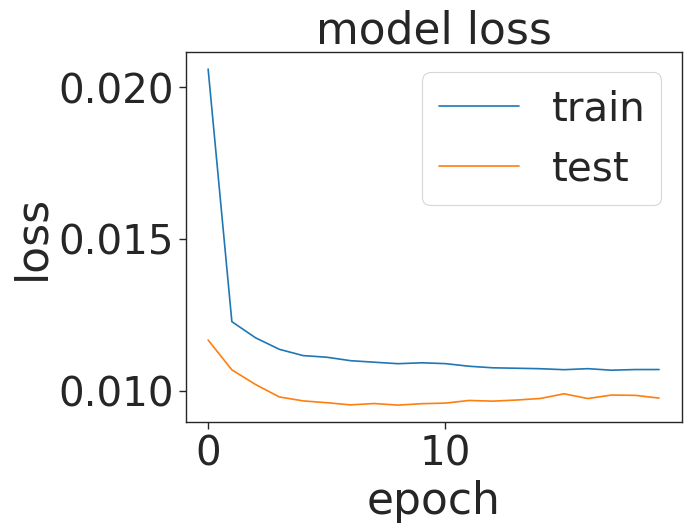

808/808 [==============================] - 2s 2ms/step
Test RMSE: 0.636


In [ ]:
model = keras.Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_x, train_y, epochs=20, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_x[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

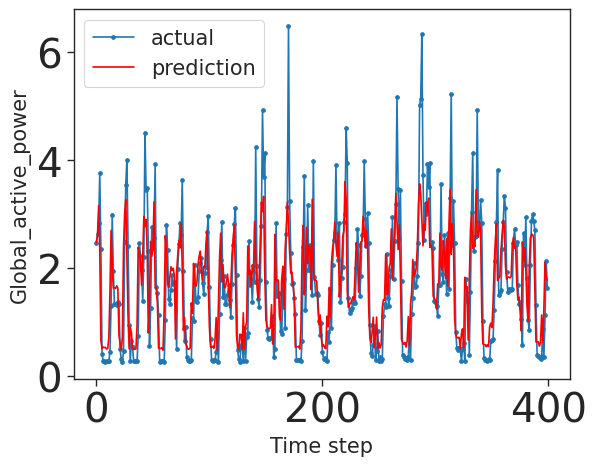

In [ ]:
aa=[x for x in range(400)]
plt.plot(aa, inv_y[:400], marker='.', label="actual")
plt.plot(aa, inv_yhat[:400], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()